In [113]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GCNConv, GATConv
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
import numpy as np
import time

import matplotlib.pyplot as plt

os.environ['PYTORCH_MPS_ENABLE_FALLBACK']='1'

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [114]:

# Function to plot training and validation loss over epochs
def plot_loss(train_losses, val_losses, save_path='loss_plot.png'):
    """
    Plots the training and validation loss over epochs.

    Args:
        train_losses (list): List of training losses.
        val_losses (list): List of validation losses.
        save_path (str): Path to save the plot image.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()
    print(f"Loss plot saved to {save_path}")


In [115]:

def preprocess_data(filepath, sample_size=10000, k=10, random_state=42):
    """
    Load the dataset, sample a subset, encode categorical features,
    normalize continuous features, and create an optimized edge list.

    Args:
        filepath (str): Path to the CSV dataset.
        sample_size (int): Number of samples to select.
        k (int): Number of neighbors to connect for each node.
        random_state (int): Seed for reproducibility.

    Returns:
        Data: PyTorch Geometric Data object with sampled data.
        dict: Encoders used for categorical features.
    """
    print("Loading dataset...")
    # Load dataset
    df = pd.read_csv(filepath)
    print(f"Original dataset size: {df.shape}")

    # Sample the dataset
    print("Sampling data...")
    if sample_size < len(df):
        df_sampled = df.sample(n=sample_size, random_state=random_state).reset_index(drop=True)
    else:
        df_sampled = df.reset_index(drop=True)
    print(f"Sampled dataset size: {df_sampled.shape}")

    # Encode categorical features
    print("Encoding categorical features...")
    encoders = {}
    categorical_cols = ['disease_family', 'disease', 'smoking_status', 'cough_type']
    for col in categorical_cols:
        if col in df_sampled.columns:
            encoder = LabelEncoder()
            df_sampled[col] = encoder.fit_transform(df_sampled[col])
            encoders[col] = encoder
            print(f"Encoded column: {col}")
        else:
            raise ValueError(f"Column '{col}' not found in the dataset.")

    # Normalize continuous features
    print("Normalizing continuous features...")
    scaler = StandardScaler()
    continuous_cols = ['systolic_bp', 'diastolic_bp', 'cholesterol', 'BMI', 'heart_rate', 'blood_glucose']
    for col in continuous_cols:
        if col in df_sampled.columns:
            df_sampled[col] = scaler.fit_transform(df_sampled[[col]])
            print(f"Normalized column: {col}")
        else:
            raise ValueError(f"Column '{col}' not found in the dataset.")

    # Prepare node features (X)
    print("Preparing node features...")
    if 'patient_id' in df_sampled.columns:
        feature_cols = [col for col in df_sampled.columns if col != 'patient_id']
        x = torch.tensor(df_sampled[feature_cols].values, dtype=torch.float)
    else:
        x = torch.tensor(df_sampled.values, dtype=torch.float)
    print(f"Node features shape: {x.shape}")

    # Create optimized edge list
    print("Creating edge list...")
    edge_index = create_edge_list_vectorized(df_sampled, k=k)
    print(f"Edge list created with shape: {edge_index.shape}")

    return Data(x=x, edge_index=edge_index), encoders


In [116]:

def create_edge_list_vectorized(df, k=10):
    """
    Optimized edge list creation using vectorized operations.
    Connect each node to k randomly selected neighbors within the same 'disease_family'.

    Args:
        df (pd.DataFrame): Sampled DataFrame.
        k (int): Number of neighbors to connect for each node.

    Returns:
        torch.Tensor: Edge index tensor of shape [2, num_edges].
    """
    print("Grouping data by 'disease_family'...")
    edges = []

    groups = df.groupby('disease_family').groups
    print(f"Number of disease families: {len(groups)}")

    for group_name, group in tqdm(groups.items(), total=len(groups), desc="Processing groups"):
        group_indices = group.values  # Assuming group is a pandas Index or similar
        num_nodes = len(group_indices)

        if num_nodes <= 1:
            print(f"Group '{group_name}' has only {num_nodes} node(s). Skipping.")
            continue  # No edges can be formed

        # Determine the actual number of neighbors
        actual_k = min(k, num_nodes - 1)

        # Shuffle the indices for randomness
        shuffled_indices = np.random.permutation(group_indices)

        # Assign the first 'actual_k' indices as neighbors
        neighbors = np.tile(shuffled_indices[:actual_k], (num_nodes, 1))

        # Create source and target edges
        source_nodes = np.repeat(group_indices, actual_k)
        target_nodes = neighbors.flatten()

        # Append to the edge list
        edges.extend(zip(source_nodes, target_nodes))

    # Convert to NumPy array for efficient processing
    edges = np.array(edges)

    print("Removing duplicate edges and self-loops...")
    # Remove self-loops
    mask = edges[:, 0] != edges[:, 1]
    edges = edges[mask]

    # Remove duplicate edges
    edges = np.unique(edges, axis=0)
    print(f"Total edges after sampling: {len(edges)}")

    if len(edges) == 0:
        raise ValueError("No edges were created. Please check the edge creation logic.")

    # Convert to PyTorch tensor
    edge_index = torch.tensor(edges, dtype=torch.long).t()

    return edge_index


In [117]:
class PatientGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super(PatientGNN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.attention = GATConv(hidden_channels, hidden_channels, heads=heads, concat=False)
        self.gcn2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.gcn1(x, edge_index)
        x = torch.relu(x)
        x = self.attention(x, edge_index)
        x = torch.relu(x)
        x = self.gcn2(x, edge_index)
        return x


In [118]:
def train(model, optimizer, criterion, data, device, batch_size=64):
    model.train()
    optimizer.zero_grad()
    
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)
    mini_batches = indices.split(batch_size)
    
    total_loss = 0
    bce_loss = torch.nn.BCEWithLogitsLoss()  # Use BCE with logits for numerical stability
    
    for batch in mini_batches:
        x_batch = data.x[batch].to(device)
        global_to_local = {global_idx.item(): local_idx for local_idx, global_idx in enumerate(batch)}
        
        # Filter and remap edges (same as before)
        mask_pos = torch.isin(data.train_pos_edge_index[0], batch) & torch.isin(data.train_pos_edge_index[1], batch)
        pos_edge_index_batch = data.train_pos_edge_index[:, mask_pos].to(device)
        pos_edge_index_batch = torch.tensor(
            [[global_to_local[node.item()] for node in pos_edge_index_batch_row]
             for pos_edge_index_batch_row in pos_edge_index_batch],
            dtype=torch.long,
            device=device,
        )
        
        mask_neg = torch.isin(data.train_neg_edge_index[0], batch) & torch.isin(data.train_neg_edge_index[1], batch)
        neg_edge_index_batch = data.train_neg_edge_index[:, mask_neg].to(device)
        neg_edge_index_batch = torch.tensor(
            [[global_to_local[node.item()] for node in neg_edge_index_batch_row]
             for neg_edge_index_batch_row in neg_edge_index_batch],
            dtype=torch.long,
            device=device,
        )
        
        out = model(x_batch, pos_edge_index_batch)
        
        # Compute positive and negative scores
        pos_src, pos_dst = pos_edge_index_batch
        neg_src, neg_dst = neg_edge_index_batch
        
        pos_out_src = out[pos_src]
        pos_out_dst = out[pos_dst]
        neg_out_src = out[neg_src]
        neg_out_dst = out[neg_dst]
        
        pos_scores = (pos_out_src * pos_out_dst).sum(dim=-1)  # Raw logits for BCE
        neg_scores = (neg_out_src * neg_out_dst).sum(dim=-1)  # Raw logits for BCE
        
        # Combine positive and negative samples for BCE
        scores = torch.cat([pos_scores, neg_scores], dim=0)
        labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)], dim=0)
        
        # Compute BCE Loss
        loss = bce_loss(scores, labels)
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        optimizer.zero_grad()
    
    return total_loss / len(mini_batches)


In [119]:

# Evaluation Function
def evaluate(model, criterion, data, split='val'):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.train_pos_edge_index)

        if split == 'val':
            pos_edge = data.val_pos_edge_index
            neg_edge = data.val_neg_edge_index
        elif split == 'test':
            pos_edge = data.test_pos_edge_index
            neg_edge = data.test_neg_edge_index
        else:
            raise ValueError("Split must be 'val' or 'test'")

        pos_src = pos_edge[0]
        pos_dst = pos_edge[1]
        neg_src = neg_edge[0]
        neg_dst = neg_edge[1]

        pos_out_src = out[pos_src]
        pos_out_dst = out[pos_dst]
        neg_out_src = out[neg_src]
        neg_out_dst = out[neg_dst]

        # Compute similarity scores
        pos_scores = (pos_out_src * pos_out_dst).sum(dim=-1)
        neg_scores = (neg_out_src * neg_out_dst).sum(dim=-1)

        # Compute loss
        pos_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-15).mean()
        neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + 1e-15).mean()
        loss = pos_loss + neg_loss

    return loss.item()


In [120]:

# Recommendation Function
def recommend_similar_patients(model, data, patient_id, top_k=5):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.train_pos_edge_index)
        embeddings = embeddings.cpu()  # Ensure embeddings are on CPU
        patient_embedding = embeddings[patient_id].unsqueeze(0)
        similarities = torch.cosine_similarity(patient_embedding, embeddings)
        recommended_patients = similarities.argsort(descending=True)[1:top_k+1]
        return recommended_patients


In [121]:

# Function to split edges into train, val, test
def split_edges(data, val_ratio=0.05, test_ratio=0.05, random_state=42):
    """
    Split the edges in data.edge_index into train, validation, and test sets.

    Args:
        data (Data): PyTorch Geometric Data object.
        val_ratio (float): Proportion of edges to use for validation.
        test_ratio (float): Proportion of edges to use for testing.
        random_state (int): Seed for reproducibility.

    Returns:
        Data: Data object with train, val, and test edge indices.
    """
    print("Splitting edges into train, validation, and test sets...")
    num_edges = data.edge_index.size(1)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)
    num_train = num_edges - num_val - num_test

    # Shuffle edge indices with reproducibility
    generator = torch.Generator().manual_seed(random_state)
    indices = torch.randperm(num_edges, generator=generator)
    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_val]
    test_indices = indices[num_train + num_val:]

    data.train_pos_edge_index = data.edge_index[:, train_indices]
    data.val_pos_edge_index = data.edge_index[:, val_indices]
    data.test_pos_edge_index = data.edge_index[:, test_indices]

    # Generate negative samples for train, val, and test
    print("Generating negative samples for training...")
    data.train_neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
        method='sparse'
    )

    print("Generating negative samples for validation...")
    data.val_neg_edge_index = negative_sampling(
        edge_index=data.val_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.val_pos_edge_index.size(1),
        method='sparse'
    )

    print("Generating negative samples for testing...")
    data.test_neg_edge_index = negative_sampling(
        edge_index=data.test_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.test_pos_edge_index.size(1),
        method='sparse'
    )

    return data


In [122]:

# Main Execution

# Filepath to dataset
filepath = 'datasets/SynDisNet.csv'  # Update this path as needed

# Set device to CUDA if available, else MPS or CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    # device = torch.device("mps") - currently not supported
    device = torch.device("cpu")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


In [123]:
# Preprocess data and create Data object with sampling
sample_size = 64000  # Number of samples to select
k = 10  # Number of neighbors per node
data, encoders = preprocess_data(filepath, sample_size=sample_size, k=k)

# Split edges into train, val, and test
data = split_edges(data, val_ratio=0.1, test_ratio=0.1, random_state=42)
print("Edge splits:")
print(f"Train edges: {data.train_pos_edge_index.size(1)}")
print(f"Validation edges: {data.val_pos_edge_index.size(1)}")
print(f"Test edges: {data.test_pos_edge_index.size(1)}")

# Move data to device
print("Moving data to device...")
data = data.to(device)


Loading dataset...
Original dataset size: (1000000, 13)
Sampling data...
Sampled dataset size: (64000, 13)
Encoding categorical features...
Encoded column: disease_family
Encoded column: disease
Encoded column: smoking_status
Encoded column: cough_type
Normalizing continuous features...
Normalized column: systolic_bp
Normalized column: diastolic_bp
Normalized column: cholesterol
Normalized column: BMI
Normalized column: heart_rate
Normalized column: blood_glucose
Preparing node features...
Node features shape: torch.Size([64000, 12])
Creating edge list...
Grouping data by 'disease_family'...
Number of disease families: 10


Processing groups: 100%|██████████| 10/10 [00:00<00:00, 94.91it/s]

Removing duplicate edges and self-loops...


Total edges after sampling: 639900
Edge list created with shape: torch.Size([2, 639900])
Splitting edges into train, validation, and test sets...
Generating negative samples for training...
Generating negative samples for validation...
Generating negative samples for testing...
Edge splits:
Train edges: 511920
Validation edges: 63990
Test edges: 63990
Moving data to device...


In [124]:


# Initialize model and move to device
in_channels = data.x.size(1)
hidden_channels = 64
out_channels = 32
heads = 4
print("Initializing model...")
model = PatientGNN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, heads=heads)
model = model.to(device)

Initializing model...


In [125]:


# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # Alternatively, use a different loss based on your task

# Training loop with progress bar
epochs = 100
best_val_loss = float('inf')
patience = 20000
counter = 0


In [126]:

# Lists to store loss values for plotting
train_losses = []
val_losses = []


In [127]:
print("Starting training...")
for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
    loss = train(model, optimizer, criterion, data, device=device, batch_size=2048)

    train_losses.append(loss)

    # Evaluate on validation set
    val_loss = evaluate(model, criterion, data, split='val')
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1

    if epoch % 10 == 0:
        print(f"raw loss: {loss}")
        print(f"Epoch {epoch}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break


Starting training...


Training Progress:   1%|          | 1/100 [00:07<12:40,  7.69s/epoch]

raw loss: 0.656806056461637
Epoch 0, Train Loss: 0.6568, Val Loss: 0.7669


Training Progress:   2%|▏         | 2/100 [00:15<12:21,  7.56s/epoch]

raw loss: 0.46165812181101906
Epoch 1, Train Loss: 0.4617, Val Loss: 0.8058


Training Progress:   3%|▎         | 3/100 [00:22<12:08,  7.51s/epoch]

raw loss: 0.4803993997592775
Epoch 2, Train Loss: 0.4804, Val Loss: 0.7472


Training Progress:   4%|▍         | 4/100 [00:30<11:58,  7.49s/epoch]

raw loss: 0.4598537543936381
Epoch 3, Train Loss: 0.4599, Val Loss: 0.7525


Training Progress:   5%|▌         | 5/100 [00:37<11:50,  7.48s/epoch]

raw loss: 0.4613083596267397
Epoch 4, Train Loss: 0.4613, Val Loss: 0.7334


Training Progress:   6%|▌         | 6/100 [00:45<11:45,  7.50s/epoch]

raw loss: 0.45115726429318626
Epoch 5, Train Loss: 0.4512, Val Loss: 0.7453


Training Progress:   7%|▋         | 7/100 [00:53<11:51,  7.65s/epoch]

raw loss: 0.4428366119899447
Epoch 6, Train Loss: 0.4428, Val Loss: 0.7881


Training Progress:   8%|▊         | 8/100 [01:01<11:59,  7.82s/epoch]

raw loss: 0.4413201773450488
Epoch 7, Train Loss: 0.4413, Val Loss: 0.7542


Training Progress:   9%|▉         | 9/100 [01:09<12:03,  7.95s/epoch]

raw loss: 0.43700157082270064
Epoch 8, Train Loss: 0.4370, Val Loss: 0.7693


Training Progress:  10%|█         | 10/100 [01:17<12:07,  8.09s/epoch]

raw loss: 0.4269550445060881
Epoch 9, Train Loss: 0.4270, Val Loss: 0.7509


Training Progress:  11%|█         | 11/100 [01:26<12:12,  8.23s/epoch]

raw loss: 0.4325215258295574
Epoch 10, Train Loss: 0.4325, Val Loss: 0.7585


Training Progress:  12%|█▏        | 12/100 [01:34<12:12,  8.33s/epoch]

raw loss: 0.4378876113702381
Epoch 11, Train Loss: 0.4379, Val Loss: 0.7577


Training Progress:  13%|█▎        | 13/100 [01:43<12:19,  8.51s/epoch]

raw loss: 0.4268800937940204
Epoch 12, Train Loss: 0.4269, Val Loss: 0.7454


Training Progress:  14%|█▍        | 14/100 [01:52<12:23,  8.64s/epoch]

raw loss: 0.42977717447848546
Epoch 13, Train Loss: 0.4298, Val Loss: 0.7399


Training Progress:  15%|█▌        | 15/100 [02:01<12:21,  8.73s/epoch]

raw loss: 0.4524406102441606
Epoch 14, Train Loss: 0.4524, Val Loss: 0.7656


Training Progress:  16%|█▌        | 16/100 [02:10<12:17,  8.78s/epoch]

raw loss: 0.4098685769334672
Epoch 15, Train Loss: 0.4099, Val Loss: 0.7479


Training Progress:  17%|█▋        | 17/100 [02:19<12:15,  8.86s/epoch]

raw loss: 0.44463724205418237
Epoch 16, Train Loss: 0.4446, Val Loss: 0.7592


Training Progress:  18%|█▊        | 18/100 [02:28<12:10,  8.91s/epoch]

raw loss: 0.41558589183148886
Epoch 17, Train Loss: 0.4156, Val Loss: 0.7425


Training Progress:  19%|█▉        | 19/100 [02:37<12:06,  8.97s/epoch]

raw loss: 0.4089949606429963
Epoch 18, Train Loss: 0.4090, Val Loss: 0.7379


Training Progress:  20%|██        | 20/100 [02:46<12:01,  9.02s/epoch]

raw loss: 0.42787669220614055
Epoch 19, Train Loss: 0.4279, Val Loss: 0.7457


Training Progress:  21%|██        | 21/100 [02:56<11:53,  9.03s/epoch]

raw loss: 0.42244104402405874
Epoch 20, Train Loss: 0.4224, Val Loss: 0.7461


Training Progress:  22%|██▏       | 22/100 [03:05<11:45,  9.05s/epoch]

raw loss: 0.4270496567090352
Epoch 21, Train Loss: 0.4270, Val Loss: 0.7397


Training Progress:  23%|██▎       | 23/100 [03:14<11:37,  9.05s/epoch]

raw loss: 0.42607919919112375
Epoch 22, Train Loss: 0.4261, Val Loss: 0.7519


Training Progress:  24%|██▍       | 24/100 [03:23<11:30,  9.09s/epoch]

raw loss: 0.4305950497824048
Epoch 23, Train Loss: 0.4306, Val Loss: 0.7646


Training Progress:  25%|██▌       | 25/100 [03:32<11:22,  9.11s/epoch]

raw loss: 0.4112026743472569
Epoch 24, Train Loss: 0.4112, Val Loss: 0.7364


Training Progress:  26%|██▌       | 26/100 [03:41<11:14,  9.12s/epoch]

raw loss: 0.4155843719130471
Epoch 25, Train Loss: 0.4156, Val Loss: 0.7460


Training Progress:  27%|██▋       | 27/100 [03:50<11:07,  9.14s/epoch]

raw loss: 0.4242199898239166
Epoch 26, Train Loss: 0.4242, Val Loss: 0.7503


Training Progress:  28%|██▊       | 28/100 [04:00<10:58,  9.15s/epoch]

raw loss: 0.4219315539276789
Epoch 27, Train Loss: 0.4219, Val Loss: 0.7545


Training Progress:  29%|██▉       | 29/100 [04:09<10:49,  9.15s/epoch]

raw loss: 0.4263814737399419
Epoch 28, Train Loss: 0.4264, Val Loss: 0.7433


Training Progress:  30%|███       | 30/100 [04:18<10:44,  9.20s/epoch]

raw loss: 0.41529738690171925
Epoch 29, Train Loss: 0.4153, Val Loss: 0.7520


Training Progress:  31%|███       | 31/100 [04:27<10:36,  9.23s/epoch]

raw loss: 0.4271274320189915
Epoch 30, Train Loss: 0.4271, Val Loss: 0.7711


Training Progress:  32%|███▏      | 32/100 [04:37<10:28,  9.24s/epoch]

raw loss: 0.44943989766022513
Epoch 31, Train Loss: 0.4494, Val Loss: 0.7373


Training Progress:  33%|███▎      | 33/100 [04:46<10:19,  9.24s/epoch]

raw loss: 0.43731110436575754
Epoch 32, Train Loss: 0.4373, Val Loss: 0.7418


Training Progress:  34%|███▍      | 34/100 [04:55<10:09,  9.24s/epoch]

raw loss: 0.4138439397017161
Epoch 33, Train Loss: 0.4138, Val Loss: 0.7388


Training Progress:  35%|███▌      | 35/100 [05:04<10:03,  9.28s/epoch]

raw loss: 0.4468325948904431
Epoch 34, Train Loss: 0.4468, Val Loss: 0.7524


Training Progress:  36%|███▌      | 36/100 [05:14<09:53,  9.28s/epoch]

raw loss: 0.41542790593608975
Epoch 35, Train Loss: 0.4154, Val Loss: 0.7436


Training Progress:  37%|███▋      | 37/100 [05:23<09:44,  9.27s/epoch]

raw loss: 0.4321577882482892
Epoch 36, Train Loss: 0.4322, Val Loss: 0.7367


Training Progress:  38%|███▊      | 38/100 [05:32<09:34,  9.26s/epoch]

raw loss: 0.4190063464736182
Epoch 37, Train Loss: 0.4190, Val Loss: 0.7497


Training Progress:  39%|███▉      | 39/100 [05:41<09:25,  9.26s/epoch]

raw loss: 0.41294322576787734
Epoch 38, Train Loss: 0.4129, Val Loss: 0.7500


Training Progress:  40%|████      | 40/100 [05:51<09:21,  9.36s/epoch]

raw loss: 0.41031160950660706
Epoch 39, Train Loss: 0.4103, Val Loss: 0.7430


Training Progress:  41%|████      | 41/100 [06:00<09:13,  9.38s/epoch]

raw loss: 0.4285687856257908
Epoch 40, Train Loss: 0.4286, Val Loss: 0.7424


Training Progress:  42%|████▏     | 42/100 [06:10<09:04,  9.39s/epoch]

raw loss: 0.4425003183266473
Epoch 41, Train Loss: 0.4425, Val Loss: 0.7403


Training Progress:  43%|████▎     | 43/100 [06:19<08:54,  9.38s/epoch]

raw loss: 0.4205110505932853
Epoch 42, Train Loss: 0.4205, Val Loss: 0.7469


Training Progress:  44%|████▍     | 44/100 [06:28<08:43,  9.35s/epoch]

raw loss: 0.4214754601319631
Epoch 43, Train Loss: 0.4215, Val Loss: 0.7483


Training Progress:  45%|████▌     | 45/100 [06:38<08:34,  9.35s/epoch]

raw loss: 0.424724876407593
Epoch 44, Train Loss: 0.4247, Val Loss: 0.7415


Training Progress:  46%|████▌     | 46/100 [06:47<08:23,  9.32s/epoch]

raw loss: 0.44665805546064224
Epoch 45, Train Loss: 0.4467, Val Loss: 0.7381


Training Progress:  47%|████▋     | 47/100 [06:56<08:14,  9.32s/epoch]

raw loss: 0.4162643173384288
Epoch 46, Train Loss: 0.4163, Val Loss: 0.7429


Training Progress:  48%|████▊     | 48/100 [07:06<08:06,  9.35s/epoch]

raw loss: 0.4220564171435341
Epoch 47, Train Loss: 0.4221, Val Loss: 0.7393


Training Progress:  49%|████▉     | 49/100 [07:15<07:58,  9.39s/epoch]

raw loss: 0.41566298783771577
Epoch 48, Train Loss: 0.4157, Val Loss: 0.7438


Training Progress:  50%|█████     | 50/100 [07:25<07:49,  9.39s/epoch]

raw loss: 0.42896585000885856
Epoch 49, Train Loss: 0.4290, Val Loss: 0.7543


Training Progress:  51%|█████     | 51/100 [07:34<07:38,  9.37s/epoch]

raw loss: 0.42425573818267337
Epoch 50, Train Loss: 0.4243, Val Loss: 0.7392


Training Progress:  52%|█████▏    | 52/100 [07:43<07:26,  9.31s/epoch]

raw loss: 0.4257367854080503
Epoch 51, Train Loss: 0.4257, Val Loss: 0.7503


Training Progress:  53%|█████▎    | 53/100 [07:53<07:18,  9.34s/epoch]

raw loss: 0.41902403391542886
Epoch 52, Train Loss: 0.4190, Val Loss: 0.7429


Training Progress:  54%|█████▍    | 54/100 [08:02<07:11,  9.38s/epoch]

raw loss: 0.429181239434651
Epoch 53, Train Loss: 0.4292, Val Loss: 0.7351


Training Progress:  55%|█████▌    | 55/100 [08:12<07:04,  9.43s/epoch]

raw loss: 0.4249508246069863
Epoch 54, Train Loss: 0.4250, Val Loss: 0.7433


Training Progress:  56%|█████▌    | 56/100 [08:21<06:57,  9.48s/epoch]

raw loss: 0.4392126921623472
Epoch 55, Train Loss: 0.4392, Val Loss: 0.7408


Training Progress:  57%|█████▋    | 57/100 [08:31<06:49,  9.52s/epoch]

raw loss: 0.4206083778824125
Epoch 56, Train Loss: 0.4206, Val Loss: 0.7437


Training Progress:  58%|█████▊    | 58/100 [08:40<06:38,  9.50s/epoch]

raw loss: 0.41879482236173415
Epoch 57, Train Loss: 0.4188, Val Loss: 0.7481


Training Progress:  59%|█████▉    | 59/100 [08:50<06:29,  9.50s/epoch]

raw loss: 0.4041957885973037
Epoch 58, Train Loss: 0.4042, Val Loss: 0.7432


Training Progress:  60%|██████    | 60/100 [08:59<06:20,  9.51s/epoch]

raw loss: 0.4239983319763153
Epoch 59, Train Loss: 0.4240, Val Loss: 0.7511


Training Progress:  61%|██████    | 61/100 [09:09<06:10,  9.50s/epoch]

raw loss: 0.4171982793107865
Epoch 60, Train Loss: 0.4172, Val Loss: 0.7499


Training Progress:  62%|██████▏   | 62/100 [09:18<06:01,  9.51s/epoch]

raw loss: 0.43283415621235255
Epoch 61, Train Loss: 0.4328, Val Loss: 0.7416


Training Progress:  63%|██████▎   | 63/100 [09:28<05:51,  9.50s/epoch]

raw loss: 0.4077041274498379
Epoch 62, Train Loss: 0.4077, Val Loss: 0.7374


Training Progress:  64%|██████▍   | 64/100 [09:37<05:41,  9.49s/epoch]

raw loss: 0.414236858960182
Epoch 63, Train Loss: 0.4142, Val Loss: 0.7438


Training Progress:  65%|██████▌   | 65/100 [09:47<05:31,  9.48s/epoch]

raw loss: 0.41950363299203297
Epoch 64, Train Loss: 0.4195, Val Loss: 0.7400


Training Progress:  66%|██████▌   | 66/100 [09:56<05:22,  9.49s/epoch]

raw loss: 0.4201903733469191
Epoch 65, Train Loss: 0.4202, Val Loss: 0.7376


Training Progress:  67%|██████▋   | 67/100 [10:06<05:12,  9.47s/epoch]

raw loss: 0.4280651221199641
Epoch 66, Train Loss: 0.4281, Val Loss: 0.7490


Training Progress:  68%|██████▊   | 68/100 [10:15<05:03,  9.50s/epoch]

raw loss: 0.4238866406773764
Epoch 67, Train Loss: 0.4239, Val Loss: 0.7362


Training Progress:  69%|██████▉   | 69/100 [10:25<04:55,  9.54s/epoch]

raw loss: 0.4170171701245838
Epoch 68, Train Loss: 0.4170, Val Loss: 0.7397


Training Progress:  70%|███████   | 70/100 [10:34<04:45,  9.50s/epoch]

raw loss: 0.4417084637615416
Epoch 69, Train Loss: 0.4417, Val Loss: 0.7391


Training Progress:  71%|███████   | 71/100 [10:44<04:34,  9.47s/epoch]

raw loss: 0.43069776490567224
Epoch 70, Train Loss: 0.4307, Val Loss: 0.7445


Training Progress:  72%|███████▏  | 72/100 [10:53<04:25,  9.48s/epoch]

raw loss: 0.42290968625318437
Epoch 71, Train Loss: 0.4229, Val Loss: 0.7390


Training Progress:  73%|███████▎  | 73/100 [11:03<04:16,  9.49s/epoch]

raw loss: 0.4221705188826909
Epoch 72, Train Loss: 0.4222, Val Loss: 0.7410


Training Progress:  74%|███████▍  | 74/100 [11:12<04:07,  9.50s/epoch]

raw loss: 0.4189572258601113
Epoch 73, Train Loss: 0.4190, Val Loss: 0.7432


Training Progress:  75%|███████▌  | 75/100 [11:22<03:57,  9.52s/epoch]

raw loss: 0.40825868102293167
Epoch 74, Train Loss: 0.4083, Val Loss: 0.7366


Training Progress:  76%|███████▌  | 76/100 [11:31<03:48,  9.50s/epoch]

raw loss: 0.42749194162232534
Epoch 75, Train Loss: 0.4275, Val Loss: 0.7404


Training Progress:  77%|███████▋  | 77/100 [11:41<03:38,  9.49s/epoch]

raw loss: 0.4355823714581747
Epoch 76, Train Loss: 0.4356, Val Loss: 0.7415


Training Progress:  78%|███████▊  | 78/100 [11:50<03:28,  9.49s/epoch]

raw loss: 0.4336168392310067
Epoch 77, Train Loss: 0.4336, Val Loss: 0.7458


Training Progress:  79%|███████▉  | 79/100 [12:00<03:19,  9.49s/epoch]

raw loss: 0.41199480683084516
Epoch 78, Train Loss: 0.4120, Val Loss: 0.7402


Training Progress:  80%|████████  | 80/100 [12:09<03:10,  9.53s/epoch]

raw loss: 0.4184550316560836
Epoch 79, Train Loss: 0.4185, Val Loss: 0.7430


Training Progress:  81%|████████  | 81/100 [12:19<03:01,  9.53s/epoch]

raw loss: 0.4097973351913785
Epoch 80, Train Loss: 0.4098, Val Loss: 0.7356


Training Progress:  82%|████████▏ | 82/100 [12:28<02:52,  9.56s/epoch]

raw loss: 0.42662558006861856
Epoch 81, Train Loss: 0.4266, Val Loss: 0.7369


Training Progress:  83%|████████▎ | 83/100 [12:38<02:43,  9.63s/epoch]

raw loss: 0.4029525603566851
Epoch 82, Train Loss: 0.4030, Val Loss: 0.7452


Training Progress:  84%|████████▍ | 84/100 [12:48<02:33,  9.59s/epoch]

raw loss: 0.4214698109361861
Epoch 83, Train Loss: 0.4215, Val Loss: 0.7358


Training Progress:  85%|████████▌ | 85/100 [12:57<02:23,  9.58s/epoch]

raw loss: 0.42255721773420063
Epoch 84, Train Loss: 0.4226, Val Loss: 0.7424


Training Progress:  86%|████████▌ | 86/100 [13:07<02:14,  9.57s/epoch]

raw loss: 0.4201539663804902
Epoch 85, Train Loss: 0.4202, Val Loss: 0.7393


Training Progress:  87%|████████▋ | 87/100 [13:17<02:04,  9.60s/epoch]

raw loss: 0.4201413622451207
Epoch 86, Train Loss: 0.4201, Val Loss: 0.7432


Training Progress:  88%|████████▊ | 88/100 [13:26<01:54,  9.57s/epoch]

raw loss: 0.4078985322562475
Epoch 87, Train Loss: 0.4079, Val Loss: 0.7418


Training Progress:  89%|████████▉ | 89/100 [13:36<01:45,  9.63s/epoch]

raw loss: 0.40569645899628837
Epoch 88, Train Loss: 0.4057, Val Loss: 0.7374


Training Progress:  90%|█████████ | 90/100 [13:45<01:36,  9.64s/epoch]

raw loss: 0.43998029615197864
Epoch 89, Train Loss: 0.4400, Val Loss: 0.7438


Training Progress:  91%|█████████ | 91/100 [13:55<01:26,  9.62s/epoch]

raw loss: 0.42153037303969976
Epoch 90, Train Loss: 0.4215, Val Loss: 0.7426


Training Progress:  92%|█████████▏| 92/100 [14:05<01:16,  9.62s/epoch]

raw loss: 0.4140307952960332
Epoch 91, Train Loss: 0.4140, Val Loss: 0.7414


Training Progress:  93%|█████████▎| 93/100 [14:14<01:07,  9.59s/epoch]

raw loss: 0.4157673075558647
Epoch 92, Train Loss: 0.4158, Val Loss: 0.7370


Training Progress:  94%|█████████▍| 94/100 [14:24<00:57,  9.59s/epoch]

raw loss: 0.42217438892712666
Epoch 93, Train Loss: 0.4222, Val Loss: 0.7470


Training Progress:  95%|█████████▌| 95/100 [14:33<00:48,  9.62s/epoch]

raw loss: 0.4057527924813921
Epoch 94, Train Loss: 0.4058, Val Loss: 0.7347


Training Progress:  96%|█████████▌| 96/100 [14:43<00:38,  9.61s/epoch]

raw loss: 0.41673913077702596
Epoch 95, Train Loss: 0.4167, Val Loss: 0.7357


Training Progress:  97%|█████████▋| 97/100 [14:53<00:28,  9.63s/epoch]

raw loss: 0.43086822804004427
Epoch 96, Train Loss: 0.4309, Val Loss: 0.7440


Training Progress:  98%|█████████▊| 98/100 [15:02<00:19,  9.58s/epoch]

raw loss: 0.4283387994482404
Epoch 97, Train Loss: 0.4283, Val Loss: 0.7396


Training Progress:  99%|█████████▉| 99/100 [15:12<00:09,  9.57s/epoch]

raw loss: 0.42013751987427
Epoch 98, Train Loss: 0.4201, Val Loss: 0.7340


Training Progress: 100%|██████████| 100/100 [15:21<00:00,  9.22s/epoch]

raw loss: 0.4023225357135137
Epoch 99, Train Loss: 0.4023, Val Loss: 0.7472


In [128]:

# Load the best model
print("Loading the best model...")
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_loss = evaluate(model, criterion, data, split='test')
print(f"Test Loss: {test_loss:.4f}")




Loading the best model...


/var/folders/70/9wgnzfm56tx44byb0jjm6llr0000gn/T/ipykernel_44027/2654965690.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

Test Loss: 0.7333


In [129]:

# Recommendations
patient_id = 0  # Example patient ID (ensure it's within the sampled data range)
if patient_id >= data.num_nodes:
    raise ValueError(f"patient_id {patient_id} is out of range for the dataset with {data.num_nodes} nodes.")

recommended_patients = recommend_similar_patients(model, data, patient_id, top_k=5)
print(f"Recommended patients for patient {patient_id}: {recommended_patients.tolist()}")

Recommended patients for patient 0: [24841, 3744, 19397, 16799, 17313]


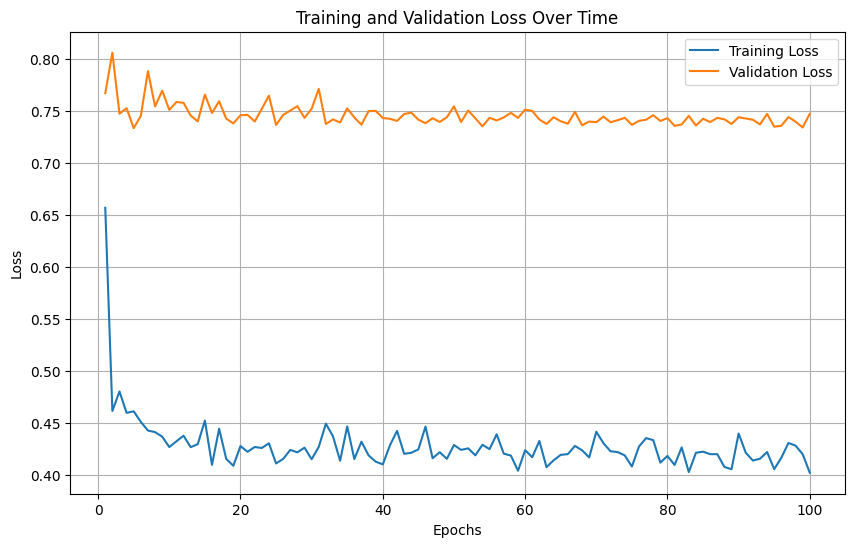

Loss plot saved to loss_plot.png


In [130]:
plot_loss(train_losses, val_losses, save_path='loss_plot.png')
